# Baseline Model: Holt Winter Exponential Smoothing (HWES)


In this notebook, we forecast the **fastest Bitcoin transaction fee (sats/vByte)** for the next 24 hours using **Holt-Winters Exponential Smoothing (HWES)**.

---

## Why HWES? Additive or Multiplicative?

HWEST is a powerful method for time series forecasting that captures both **trend** and **seasonality**. It can handle both **additive** and **multiplicative** seasonality, making it flexible for different types of data. 

Recall from our EDA that Bitcoin transactions fees are proven both stationary and have a minimal fee of 1 sat/vByte, which suggests that dataset is fit for multiplicative modeling as all values are strictly positive. In addition, we analyzed the seasonality and trend of the time series using both **additive** and **multiplicative** decompositions. Here's what we found:

**✅ Additive Decomposition**

- Seasonal pattern has **constant amplitude** regardless of trend level.
- Works well when seasonality is **independent of the trend level**.
- Residuals look okay but large spikes (likely outliers) are present.

✅ **Multiplicative Decomposition**

- Seasonal component **scales with the level of the series** (i.e., as fees rise, seasonal amplitude increases).
- This fits **real-world Bitcoin fee behavior more accurately**:
    - High congestion periods (e.g., spikes in March) show **amplified seasonal patterns**.
    - Multiplicative seasonality captures this well.
- Residuals are tighter and better-behaved around 0 compared to additive, except for extreme spikes, which are expected.

⚠️ **Note:** Multiplicative models require **strictly positive values**.

This notebook walks through the full pipeline of the HWES model. For model training and implementation, please refer to `scripts/baseline_hwes.py`.


In [2]:
import os
import sys  
import pickle

import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from sklearn.preprocessing import MinMaxScaler
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))
from plot_series import plot_series
from custom_loss_eval import eval_metrics
from preprocess_raw_parquet import preprocess_raw_parquet

## 1. Prepare Raw Data for HWES

In this step, we transform the raw Bitcoin mempool and fee dataset into a clean, long-format structure optimized for HWES. This involves:

- Removing noise and irrelevant features
- Resampling at 15-minute intervals for uniform time steps
- Ensuring no zero values to ensure model compatibility
- Select the target column: `recommended_fee_fastestFee`  
- Drop the final 96 time points (1 day of 15-min intervals) to avoid distortion from extreme values
- Perform temporal train test split with last 24 hours as test set

In [ ]:
# Define key modeling parameters
FREQ = "15min"        # Time resolution of the data
PRED_STEPS = 96       # Prediction length: 1 day = 96 × 15min

In [7]:
# Load preprocessed data
df_resampled = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df_resampled.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Extract target series
y = df_resampled['recommended_fee_fastestFee']

# Drop the final spike day (2025-05-11 20:00 onward = last 96 points)
y = y.iloc[:-PRED_STEPS]

In [10]:
# Split data into train/validation sets and normalize
y_train = y[:-PRED_STEPS]
y_test = y[-PRED_STEPS:]

### Why This Step Is Crucial for HWES
- Maintains temporal integrity: Ensures the target series reflects real-world sequential ordering without gaps.
- Enables seasonal-trend modeling: Clean, evenly spaced data is essential for HWES to detect and learn seasonal and trend components.
- Ensures numerical validity: HWES cannot handle zero values; filtering out or adjusting zero entries ensures model compatibility and prevents runtime errors.
- Avoids contamination: Ensures no leakage from past data or exogenous variables, preserving the model’s univariate nature.

## 2. Hyperparameter Tuning

In this step, we search for the best configuration of HWES smoothing parameters to fit the Bitcoin fee series. This includes:

- Deciding between additive or multiplicative for trend and seasonal components
- Testing damped vs. non-damped trend options

The best hyperparameters for the HWES model were determined through a grid search with cross-validation. The parameters were optimized to minimize a customized evaluation metric, which is combination of MAE, standard deviation penalty, shape penalty on the validation set. For details on the evaluation metric, please refer to the `custom_loss_eval.py` script under `src` folder.

All hyperparameter optimization logic is implemented in: `scripts/hwes/hwes_cv_optimization.py`

In [6]:
# # Load cross-validation hyperparameter combination results
# cv_results pd.read_csv("../results/tables/hwes_cv_results.csv")

# # Extract the best hyperparameters from the cross-validation results
# best_trend, best_seasonal, best_damped = cv_results.iloc[0][['trend', 'seasonal', 'damped']]
# print(f"Best HWES parameters: trend={best_trend}, seasonal={best_seasonal}, damped={best_damped}")

### Why This Step Is Crucial for HWES
- Ensures model structure aligns with data characteristics (e.g., multiplicative seasonality for percentage-based variation)
- Determines how the model captures underlying trend and recurring fee patterns
- Balances model flexibility with stability to avoid overfitting
- Enhances short-term and seasonal forecast accuracy

### Insights from Hyperparameter Tuning

The best hyperparameter combination found through grid search is: 'multiplicative' trend, 'multiplicative' seasonality, and a damped trend. This configuration captures the multiplicative nature of Bitcoin fees while allowing for a damped trend to prevent overfitting to extreme spikes.

This result confirms our initial observations and hypothesis that bitcoin transaction fees are of multiplicative nature with daily seasonality. These hyperparameters are used to fit the HWES model, make forecasts, and experimentations around length of training window needed to achieve generalization.

## 3. (OPTIONAL) Model Generalization Experimentation

To assess how well HWES generalizes over time, we implement three weekly cross-validation strategies:

- **Expanding Window**: Trains from week 1 and expands one week at a time.  
- **Sliding Window**: Uses a fixed 1-week window that shifts forward.  
- **Reverse Expanding Window**: Starts from the second-to-last week and expands backward.  

All windowing logic is implemented in: `scripts/experimentation/hwes_window.py`
> **Note:** This script also includes instructions on how to run the experiments and generate results.

### 3.1 Expanding Window Forecasting - Weekly

We use expanding window cross-validation to evaluate HWES’s performance by adding the most recent weekly data (+7-day training, 1-day testing). This simulates a real-world setup where the model is retrained weekly using all past data and evaluated on the upcoming week.

**Key motivations:**

- Test HWES’s stability over longer time horizons  
- Identify periods of high error (e.g., spikes, market shifts)  
- Improve model readiness for production retraining  

Saved output: `results/tables/hwes/hwes_experimentation_exp_win.csv`

In [7]:
# # Load expanding window experimentation results
# exp_win_df = pd.read_csv("../results/tables/hwes/hwes_experimentation_exp_win.csv")
# exp_win_df

### 3.2 Expanding Window Forecasting – Weekly – Reverse

We use reverse expanding window cross-validation to examine how the inclusion of different historical periods affects SARIMA’s ability to forecast the same target period.  
The model always predicts the **last 24 hours**, while the training window grows **backward** step by step in weekly increments. This setup simulates situations where older and older historical data is gradually added to training.

**Key motivations:**

- Evaluate HWES’s temporal sensitivity to historical context  
- Assess robustness to structural changes in past data  
- Understand how training on different time ranges impacts forecast stability  

Saved output: `results/tables/hwes/hwes_experimentation_rev_exp_win.csv`

In [ ]:
# # Load reverse expanding window experimentation results
# rev_exp_win_df = pd.read_csv("../results/tables/hwes/hwes_experimentation_rev_exp_win.csv")
# rev_exp_win_df

### 3.3 Sliding Window Forecasting – Weekly

We apply a **sliding window** strategy using a fixed 7-day training window and a 1-day test window (96 × 15-minute intervals).  
This setup simulates a realistic retraining schedule where the model is updated regularly using only the most recent week of data.

**Key motivations:**

- Evaluate HWES’s short-term adaptability across time  
- Examine model behavior under a fixed training history  
- Identify periods of degraded performance (e.g., sudden fee spikes)  

Saved output: `results/tables/hwes/hwes_experimentation_exp_win.csv`

In [9]:
# # Load reverse expanding window experimentation results
# slide_exp_win_df = pd.read_csv("../results/tables/hwes/hwes_experimentation_slide_win.csv")
# slide_win_df

### 3.4 Insights from Experimentation

TO BE ADDED

### 3.4 Why This Step Is Crucial

Cross-validation across different weekly windowing approaches is key to assessing how well the model generalizes under varying temporal conditions.

- **Expanding window** captures the model’s ability to accumulate and leverage long-term patterns.  
- **Sliding window** tests how well the model adapts with fixed-size training windows and frequent retraining.  
- **Reverse expanding window** examines the impact of training length and distant history on forecast accuracy.  

These strategies collectively:

- Highlight time periods with unstable performance, such as during sudden fee surges or regime changes  
- Ensure model consistency across different forecasting scenarios  
- Demonstrate SARIMA’s robustness in both stable and shifting environments  

This thorough validation process builds trust in SARIMA’s suitability for deployment with recurring retraining schedules.

## 4. Model Fitting and Forecasting

The final HWES model is trained on the full dataset, excluding the last 24 hours (2025-05-10 to 2025-05-11), in line with our window-based validation strategy.  
We save the trained model to `results/models/hwes_best_train.pkl` under `results/models`folder for use in downstream inference and reproducibility.

In the next step, we load this saved model to regenerate the 1-day forecast and evaluate its performance on the holdout period.

In [11]:
# # read in training model (hwes_best_train model object)
# with open('../results/models/hwes_best_train.pkl', 'rb') as f:
#     model_fit = pickle.load(f)

# y_forecast = model_fit.forecast(PRED_STEPS)

# # Save the forecast results
# forecast_df = pd.DataFrame(y_forecast, columns=['forecast'])
# forecast_df.index = y_test.index

### Why This Step Is Crucial

- This represents the finalized HWES model intended for deployment in real-time forecasting.  
- It is fitted using the full historical dataset, excluding the final day, and evaluated on the most recent time window.  
- Maintains consistency with the evaluation procedure used for other models (e.g., SARIMA, XGBoost).  
- Pickling the model to disk ensures reproducibility and allows for seamless integration into dashboards, APIs, or automated workflows.


## 5. Performance Evaluation

This step assesses the quality of the final HWES model using both forecast accuracy and residual diagnostics. It includes:

- Quantitative evaluation on the 24-hour test set using standard and custom metrics  
- Visualization of forecasted vs. actual values to assess trend and seasonality tracking  
- Residual analysis to check for autocorrelation, normality, and heteroskedasticity  


### 5.1 Evaluation Metrics

We first evaluate the HWES model's forecast accuracy on the 24-hour holdout period (2025-05-10 to 2025-05-11).  
The following metrics are reported:

- **MAE (Mean Absolute Error)** – measures average absolute forecast error  
- **RMSE (Root Mean Squared Error)** – penalizes larger errors more heavily  
- **MAPE (Mean Absolute Percentage Error)** – normalizes errors relative to actual values  
- **Custom loss** – sum of MAE, standard deviation difference, and deviation error, designed to penalize poor performance during volatile periods, detailed in `comprehensive_overview.ipynb`

In [ ]:
# # Show evaluation metrics through custom evaluation function
# eval_results = eval_metrics(y_forecast, y_test)
# eval_results

### 5.2 Forecast vs. Actual Visualization

To complement the numerical evaluation, we plot the HWES forecast against actual fees over the 24-hour test window.  
This helps visually assess:

- How well the model captures short-term trends and seasonal effects  
- Whether there are systematic lags or missed peaks in the forecast  
- Overall alignment between predicted and true values  

The plot confirms that while HWES tracks general patterns, it underperforms during rapid fee changes—highlighting its limitations in high-volatility conditions.

In [ ]:
# plt.figure(figsize=(14, 6))
# plt.plot(y_test["timestamp"], y_test["recommended_fee_fastestFee"], label="Actual")
# plt.plot(forecast_df["timestamp"], forecast_df["forecast"], label="Forecast")

# xticks = y_test["timestamp"][::16]  # Show every 16th timestamp (4 hours)
# plt.xticks(xticks, rotation=0)

# plt.title("HWES Forecast - Fastest Bitcoin Transaction Fee (sats/vByte)")
# plt.xlabel("Time")
# plt.ylabel("Fee")
# plt.ylim(bottom=0)
# plt.legend()
# plt.grid(True)
# plt.show()

### 5.3 Residual Diagnostics

The residuals of the HWES model were analyzed to check for patterns or issues. We checked for normality and uncorrelation. This is crucial for validating the model's performance.

We have used: 
- Ljung-Box test to check for autocorrelation in the residuals. The results indicated that the residuals were not fully independent, suggesting that there may be some patterns or structures in the data that the model did not capture.
- QQ plot to check for normality of the residuals. The residuals did not follow a perfect normal distribution, indicating that there may be some outliers or non-normal behavior in the data.
- Heteroskedasticity ARCH test to check for Autoregressive Conditional Heteroskedasticity (ARCH) effects in the residuals. The results indicated that the residuals were not homoscedastic, suggesting that the variance of the residuals was not constant over time.

In [13]:
# # Calculate the residuals
# train_fitted = model_fit.fittedvalues
# train_residuals = Y_train["recommended_fee_fastestFee"] - train_fitted.values

In [117]:
# Check for Autocorrelation (Ljung-Box Test)
# p-value < 0.05 indicates significant autocorrelation
lb_test = acorr_ljungbox(train_residuals.dropna(), lags=[DAILY], return_df=True)
lb_test


,lb_stat,lb_pvalue
96,381.044905,1.330475e-35


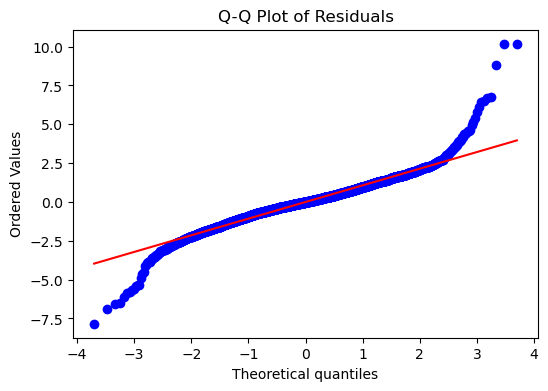

In [118]:
# Check for Normality (Q-Q Plot)
plt.figure(figsize=(6, 4))
stats.probplot(train_residuals.dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


In [120]:
# Check for Heteroskedasticity
# p-value < 0.05 indicates heteroskedasticity
arch_test = het_arch(train_residuals.dropna())
print(f"ARCH test p-value: {arch_test[1]}")

ARCH test p-value: 2.991636846964965e-211


### Key Insights from Performance Evaluation

- The HWES model produced forecasts for the final 24 hours, but struggled to capture sharp movements in transaction fees  
- Evaluation metrics (e.g., MAE = 1.16, RMSE = 1.44) indicate moderate accuracy, but the custom loss revealed penalties tied to variance and deviation  
- Residual analysis showed significant autocorrelation (Ljung-Box p < 0.001) and heteroskedasticity (ARCH p < 0.001), suggesting missed temporal and volatility patterns and the model could not fully capture the underlying dynamics of the Bitcoin transaction fees
- Visual plots confirmed that while HWES captured broad seasonal patterns, it failed to adapt during high-volatility windows  

Overall, HWES serves as a useful baseline but lacks the flexibility to handle the noisy and spike-prone nature of Bitcoin transaction fees.

### 5.5 Why This Step Is Crucial

- Validates how well the HWES model generalizes to unseen data  
- Highlights whether the model can reliably forecast fee dynamics, especially during volatile periods  
- Residual diagnostics reveal model limitations and whether key assumptions (e.g. uncorrelated, homoscedastic errors) are violated  
- Provides a transparent benchmark for comparing HWES against more complex models (e.g., SARIMA, XGBoost, TFT)  

## 6. Conclusion: Holt-Winters Exponential Smoothing (HWES) for Bitcoin Fee Forecasting

In this notebook, we implemented and evaluated the Holt-Winters Exponential Smoothing (HWES) model to forecast Bitcoin transaction fees over the next 24 hours. The workflow included:

- **Preprocessing the target time series**, with resampling, continuity checks, and spike removal to ensure clean input.  
- **Selecting the HWES configuration**, including trend, multiplicative seasonality, and seasonal period based on domain understanding.  
- **Training the final model** on all available data except the last 24 hours to align with temporal hold-out evaluation.  
- **Generating and visualizing forecasts**, comparing predicted values to actual fees on the test set.  
- **Evaluating model accuracy** using MAE, RMSE, MAPE, and custom loss components that penalize variance and deviation errors.  
- **Performing residual diagnostics**, including autocorrelation checks (Ljung-Box), normality (Q-Q plot), and heteroskedasticity (ARCH test).  

### Key Takeaways:
- HWES was able to model broad seasonal trends but struggled to adapt to high-volatility segments in the fee series.  
- Forecast metrics and residual patterns revealed unmodeled structure, indicating the limits of HWES’s univariate, exponential formulation.  
- Diagnostic tests showed significant autocorrelation and non-constant variance, suggesting that the model failed to fully capture temporal dependencies.

While HWES serves as a strong baseline and is interpretable and efficient, its limitations prompt further exploration. In upcoming notebooks, we will investigate:

- **Prophet**, which offers more flexible handling of seasonality, holidays, and changepoints.  
- **SARIMA**, for more granular modeling of autocorrelation and seasonality with statistical rigor.  
- **Machine learning models**, including **XGBoost**, **LSTM**, and **Transformer-based architectures**, to capture nonlinearities, exogenous features, and long-term dependencies.

These next steps aim to improve forecasting accuracy and provide a more robust model for anticipating Bitcoin transaction fee dynamics under real-world volatility.